<a href="https://colab.research.google.com/github/cbadenes/notebooks/blob/main/probabilistic_topic_models/Dynamic_Topic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install gensim

In [9]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# Para procesamiento de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Para modelado de tópicos
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# Configuración inicial
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
import json
import pandas as pd

rows = []
with open("News_Category_Dataset_v3.json", "r") as f:
    for line in f:
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError:
            continue  # ignora líneas con errores

df = pd.DataFrame(rows)
print(f"Cargadas {len(df)} líneas válidas")


Cargadas 209527 líneas válidas


In [12]:
# Tomar un subset manejable (200 noticias de 2015-2016)
mask = (df['date'] >= '2015-01-01') & (df['date'] <= '2016-12-31')
df = df[mask].sample(n=200, random_state=42)

# Convertir fechas a datetime y ordenar
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print("Dimensiones del dataset:", df.shape)
print("\nRango temporal:", df['date'].min(), "-", df['date'].max())
print("\nCategorías disponibles:", df['category'].unique())

Dimensiones del dataset: (200, 6)

Rango temporal: 2015-01-08 00:00:00 - 2016-12-30 00:00:00

Categorías disponibles: ['BUSINESS' 'POLITICS' 'PARENTS' 'GREEN' 'ARTS' 'STYLE' 'GOOD NEWS'
 'QUEER VOICES' 'FIFTY' 'WORLDPOST' 'HEALTHY LIVING' 'WEIRD NEWS'
 'ENTERTAINMENT' 'COMEDY' 'SPORTS' 'CRIME' 'WOMEN' 'TASTE' 'IMPACT'
 'BLACK VOICES' 'EDUCATION' 'TRAVEL' 'RELIGION' 'THE WORLDPOST' 'MEDIA'
 'SCIENCE' 'TECH' 'ARTS & CULTURE' 'LATINO VOICES']


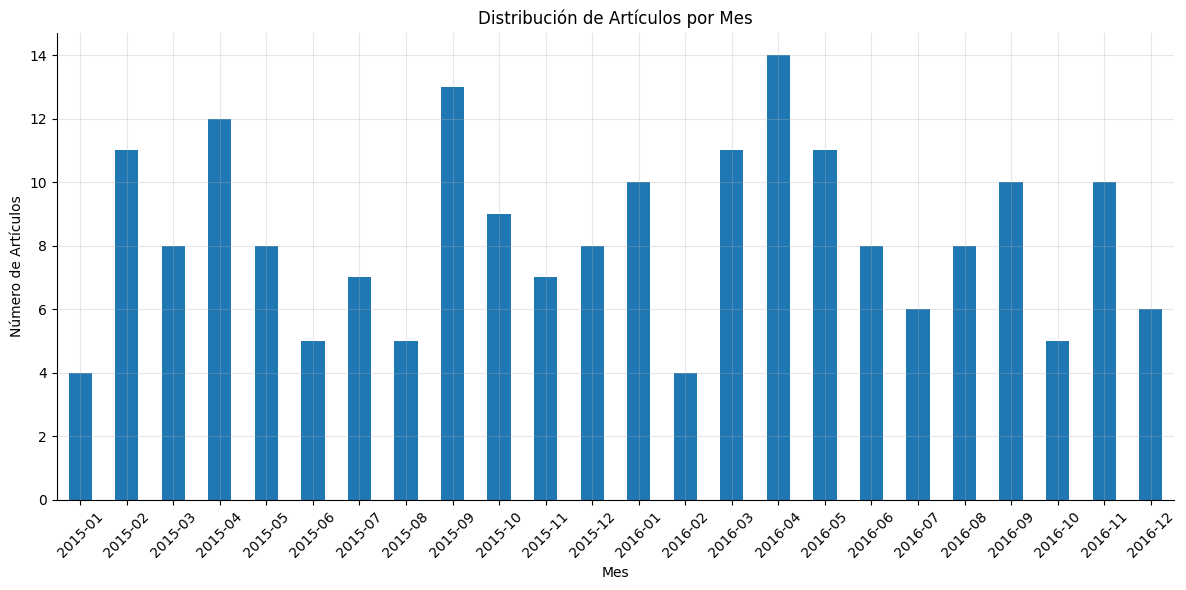

In [13]:
# Visualización de distribución temporal
plt.figure(figsize=(12, 6))
df['date'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Artículos por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
def preprocess_text(text):
    """
    Preprocesa el texto para análisis de tópicos
    """
    # Inicializar herramientas
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenizar
    tokens = word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens

# Combinar título y descripción para el análisis
df['text'] = df['headline'] + ' ' + df['short_description']

# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_text)

# Verificar el preprocesamiento
print("\nEjemplo de preprocesamiento:")
print("Original:", df['text'].iloc[0])
print("Procesado:", df['processed_text'].iloc[0])


Ejemplo de preprocesamiento:
Original: 32 Data Breaches Larger Than Sony's in the Past Year The Sony Hack was not even one of the ten largest hacks of 2014. Though large, it actually only ranks as the 33rd largest of the year in terms of number of records breached. EBay actually suffered the largest data breach of 2014 (and the second largest since 2005) with more than 150 million records compromised.
Procesado: ['data', 'breach', 'larger', 'sonys', 'past', 'year', 'sony', 'hack', 'even', 'one', 'ten', 'largest', 'hack', 'though', 'large', 'actually', 'rank', 'largest', 'year', 'term', 'number', 'record', 'breached', 'ebay', 'actually', 'suffered', 'largest', 'data', 'breach', 'second', 'largest', 'since', 'million', 'record', 'compromised']


In [15]:
# Crear diccionario
dictionary = Dictionary(df['processed_text'])

# Filtrar términos poco frecuentes o muy comunes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crear corpus
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

# Preparar time_slices (documentos por mes)
df['month'] = df['date'].dt.to_period('M')
time_slices = df.groupby('month').size().tolist()
print("\nNúmero de periodos temporales:", len(time_slices))



Tamaño del vocabulario: 71

Número de periodos temporales: 24


In [18]:
# Configurar y entrenar modelo
num_topics = 10  # Número de tópicos a detectar
chain_variance = 0.400  # Controla la suavidad de la evolución temporal

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=10
)


/usr/local/lib/python3.12/dist-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [19]:
def print_topic_evolution(model, periods=None):
    """
    Imprime la evolución de tópicos a lo largo del tiempo
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeríodo {t}:")
        for topic in range(model.num_topics):
            # La nueva sintaxis no usa el parámetro 'topics'
            top_terms = model.print_topics(time=t)[topic]
            print(f"Tópico {topic}: {top_terms[:5]}")

# Mostrar evolución de tópicos
print_topic_evolution(dtm)


Período 0:
Tópico 0: [('political', np.float64(0.09153671298190408)), ('new', np.float64(0.07854441835766096)), ('last', np.float64(0.07529872982888605)), ('attack', np.float64(0.044065828943834214)), ('group', np.float64(0.03417292989318745))]
Tópico 1: [('pay', np.float64(0.18332593285934992)), ('killed', np.float64(0.09425084343067597)), ('trump', np.float64(0.06730981920480188)), ('people', np.float64(0.058031055784369644)), ('donald', np.float64(0.044738599503138604))]
Tópico 2: [('race', np.float64(0.09913743684325553)), ('hillary', np.float64(0.07099155815459682)), ('clinton', np.float64(0.06882259736225123)), ('trump', np.float64(0.0469259744814983)), ('donald', np.float64(0.039202603896592435))]
Tópico 3: [('president', np.float64(0.2951451647343975)), ('home', np.float64(0.2785381507459288)), ('woman', np.float64(0.09938020941991117)), ('black', np.float64(0.07273526873474798)), ('need', np.float64(0.06699649106945677))]
Tópico 4: [('day', np.float64(0.3405043358952744)), ('

# 8. EJERCICIOS PROPUESTOS
# -----------------------

"""
1. Ajuste de Parámetros:
   - Modifica num_topics y observa los cambios
   - Experimenta con diferentes chain_variance
   - Prueba diferentes granularidades temporales

2. Análisis Temporal:
   - ¿Cómo cambian los tópicos mes a mes?
   - ¿Hay eventos específicos que afecten los tópicos?
   - ¿Qué categorías son más estables/variables?

3. Visualizaciones Adicionales:
   - Crea un heatmap de evolución temporal
   - Visualiza la similitud entre tópicos
   - Grafica la evolución de categorías específicas

4. Preprocesamiento:
   - Añade/elimina stopwords
   - Incluye bigramas
   - Modifica los filtros de frecuencia
"""

In [ ]:
# Guardar el modelo
dtm.save('dtm_model')

# Exportar tópicos por periodo a un CSV
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # Obtener tópicos para este período
    topics = dtm.print_topics(time=t)

    # Guardar cada tópico
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[1]  # topic_terms[1] contiene los términos

    topics_over_time[t] = period_topics

# Convertir a DataFrame
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# Guardar en CSV
topics_df.to_csv('topics_evolution.csv')

print("\nResultados guardados:")
print("- Modelo: dtm_model")
print("- Evolución de tópicos: topics_evolution.csv")


Resultados guardados:
- Modelo: dtm_model
- Evolución de tópicos: topics_evolution.csv
